In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from collections import namedtuple
from multiprocessing import Pool
from itertools import repeat

from definitions import ROOT_DIR
from unc.utils import load_info
from unc.utils.data import half_dist_prob
from unc.utils.viz.colors import emerald, peter_river, pumpkin, green_sea, midnight_blue, sunflower

plt.rcParams.update({'font.size': 18})

/Users/ruoyutao/Documents/uncertainty/venv/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:

fig_path = Path(ROOT_DIR, 'results', 'rs_results.pdf')

all_paths = {
    'rg': Path(ROOT_DIR, 'results', 'rg_nn'),
    'rg_lstm': Path(ROOT_DIR, 'results', 'rg_lstm'),
#     'rxg': Path(ROOT_DIR, 'results', 'rxg'),
    'rpg': Path(ROOT_DIR, 'results', 'rpg_nn'),
    'rsg': Path(ROOT_DIR, 'results', 'rsg_nn')
}
plot_info = {
    'rg': {'color': green_sea, 'label': 'Normal'},
    'rg_lstm':  {'color': sunflower, 'label': 'LSTM'},
    'rpg': {'color': pumpkin, 'label': 'PF (uncertainty)'},
#     'rxg': {'color': 'purple', 'label': 'rxg: Ground-truth check obs, |o| = 49 + 8'},
    'rsg': {'color': midnight_blue, 'label': 'Ground-truth'}
}
split_by = ['buffer_size', 'step_size', 'algo', 'rock_obs_init', 'arch', 'trunc']
Args = namedtuple('args', split_by)



def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [3]:
def get_discounted_returns(ep_lengths, ep_rews, discount=0.99):
    assert ep_lengths.sum() == ep_rews.shape[0]

    discounted_returns = []
    current_ep_disc_rew = 0
    idx = 0

    for ep_len in ep_lengths:
        for i in range(ep_len):
            current_ep_disc_rew += ep_rews[idx] * (discount ** i)
            idx += 1
        discounted_returns.append(current_ep_disc_rew)
        current_ep_disc_rew = 0
    discounted_returns = np.array(discounted_returns)
    
    assert discounted_returns.shape[0] == ep_lengths.shape[0]
    
    return discounted_returns

In [4]:
def process_dir(dir_path, split_by, w=100, discount=0.99):
    all_results = {}

        
    for f in tqdm(list(dir_path.iterdir())):
        if not f.is_file() or f.suffix != '.npy':
            continue
        info = load_info(f)
        args = info['args'].item()
        if "trunc" not in args:
            args['trunc'] = 0
        if "arch" not in args:
            args['arch'] = 'nn'
        
        if args['seed'] < (2020 + 10):
            continue
        result = get_discounted_returns(info['episode_length'], info['reward'], discount)

        hparams = Args(*tuple(args[s] for s in split_by))

        if hparams not in all_results:
            all_results[hparams] = []

        all_results[hparams].append((info['episode_length'], result, args))

    
    return all_results

def starmap_with_kwargs(pool, fn, args_iter, kwargs_iter):
    args_for_starmap = zip(repeat(fn), args_iter, kwargs_iter)
    return pool.starmap(apply_args_and_kwargs, args_for_starmap)

def apply_args_and_kwargs(fn, args, kwargs):
    return fn(*args, **kwargs)
    

In [5]:
# keys = []
# paths = []

# for k, v in all_paths.items():
#     keys.append(k)
#     paths.append((v, split_by))

# kwargs_iter = repeat(dict(discount=0.99))

# with Pool() as pool:
#     all_rews = starmap_with_kwargs(pool, process_dir, paths, kwargs_iter)
discount = 0.99
raw_data = {}

for key, v in all_paths.items():
    processed = process_dir(v, split_by, discount=discount)
    raw_data[key] = processed

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

In [6]:
list(raw_data[key].values())[0][0]

(array([ 602, 1000,  289, ...,   59,  135,   16]),
 array([  0.43719647, -16.93104919,  -1.87089783, ...,  17.45157482,
         21.62161621,  35.74666392]),
 {'epsilon': 0.1,
  'distance_unc_encoding': False,
  'distance_noise': False,
  'resample_interval': 1,
  'blur_prob': 0.3,
  'tile_code_gvfs': False,
  'optim': 'adam',
  'same_k_rnn_params': False,
  'update_weight_interval': 1,
  'atoms': 51,
  'v_min': -10,
  'offline_eval_freq': 2500,
  'total_steps': 1500000,
  'env': 'rsg',
  'discounting': 0.99,
  'buffer_size': 100000,
  'p_prefilled': 0.0,
  'fixed_gvf_path': None,
  'epsilon_start': 1.0,
  'algo': 'sarsa',
  'gvf_tiles': 8,
  'save_all_checkpoints': False,
  'max_episode_steps': 1000,
  'unnormalized_counts': False,
  'seed': 2057,
  'arch': 'nn',
  'platform': 'cpu',
  'uncertainty_decay': 1.0,
  'weight_init': 'fan_avg',
  'size': 9,
  'results_dir': PosixPath('/home/taodav/scratch/uncertainty/results/rsg_nn'),
  'test_eps': 0.0,
  'step_size': 0.0001,
  'save_model'

In [7]:
# we average the discounted episodic rewards over the final 100 episodes.

def get_eps_max_over(data, eps_max_over=100):
    hparam_results = []
    for args, all_dis_rew in data.items():
        final_max = np.mean([np.mean(dis_rew[-100:]) for length, dis_rew, all_args in all_dis_rew])
        hparam_results.append((args, final_max))
    return hparam_results


In [8]:
eps_max_over = 100
all_max_over = {}
for key, v in raw_data.items():
    all_max_over[key] = get_eps_max_over(v, eps_max_over)

In [9]:
# Get the best hyperparams based on the final 100 episodes
all_best = {}
for key, v in all_max_over.items():
    all_best[key] = sorted(v, key=lambda x : x[1], reverse=True)[0]

all_best

{'rg': (args(buffer_size=100000, step_size=0.001, algo='sarsa', rock_obs_init=0.5, arch='nn', trunc=10),
  13.634157434551033),
 'rg_lstm': (args(buffer_size=100000, step_size=0.0001, algo='sarsa', rock_obs_init=0.0, arch='lstm', trunc=10),
  17.81599469455601),
 'rpg': (args(buffer_size=100000, step_size=0.001, algo='sarsa', rock_obs_init=0.0, arch='nn', trunc=10),
  31.13496672244441),
 'rsg': (args(buffer_size=100000, step_size=0.0001, algo='sarsa', rock_obs_init=0.0, arch='nn', trunc=10),
  35.124370192078)}

In [10]:
# Now we map our discounted episodic rewards back to steps. We assign the discounted reward achieved at the 
# end of and episode to each timestep within the episode


def map_dis_rew_to_steps(data, w=1000, trunc=1e6):
    all_seeds = []
    for lengths, dis_rews, _ in data:
        current_seed = []
        for length, dis_rew in zip(lengths, dis_rews):
            current_seed.append(np.zeros(length) + dis_rew)
#         all_seeds.append(np.concatenate(current_seed)[:trunc])
        all_seeds.append(moving_avg(np.concatenate(current_seed)[:trunc], w=w))
    return np.array(all_seeds)

In [11]:
trunc = int(1.5e6)
window = 3000
all_mapped_data = {}
for key, v in all_best.items():
    arg = v[0]
    best_data = raw_data[key][arg]
    all_mapped_data[key] = map_dis_rew_to_steps(best_data, trunc=trunc, w=window)

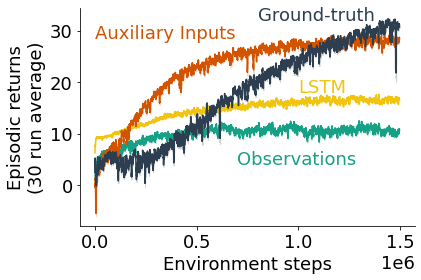

In [12]:
fig, ax = plt.figure(), plt.axes()


for k, v in all_mapped_data.items():
    data = v
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1])

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / data.shape[0]

    ax.plot(x, means, label=key, color=color, rasterized=True)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2, rasterized=True)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Episodic returns\n(30 run average)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.text(0.7e6, 4, "Observations", color=plot_info['rg']['color'], fontdict=dict(size=18))
plt.text(0.0, 28.5, "Auxiliary Inputs", color=plot_info['rpg']['color'], fontdict=dict(size=18))
plt.text(1e6, 18, "LSTM", color=plot_info['rg_lstm']['color'], fontdict=dict(size=18))
plt.text(0.8e6, 32, "Ground-truth", color=plot_info['rsg']['color'], fontdict=dict(size=18))

fig.savefig(fig_path, bbox_inches='tight')
# ax.set_title(f'Discounted episodic returns over environment steps')
# plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')


In [16]:
ax.get_ylim()

NameError: name 'ax' is not defined

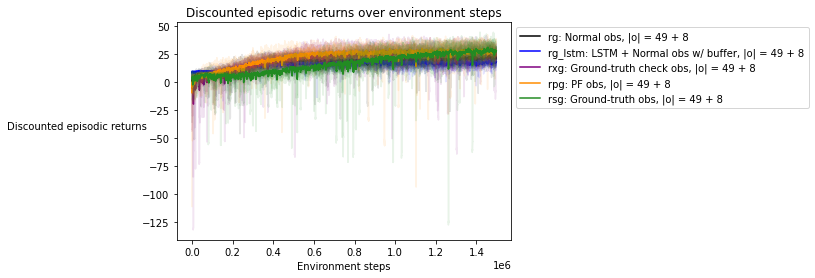

In [71]:
# Here we do individual plots and no std errors
fig, ax = plt.figure(), plt.axes()

for k, v in all_mapped_data.items():
    data = v
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1])    
    for d in data:
        ax.plot(x, d, color=color, alpha=0.1)
    means = data.mean(axis=0)

    ax.plot(x, means, label=key, color=color)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Discounted episodic returns", rotation=0, labelpad=65)
ax.set_title(f'Discounted episodic returns over environment steps')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

In [37]:
# Now for RPG q-learning vs esarsa vs sarsa plots
def group_by(dataset, key):
    grouped_data = {}
    for args, d in dataset.items():
        key_val = getattr(args, key)
        if key_val not in grouped_data:
            grouped_data[key_val] = {}
        
        grouped_data[key_val][args] = d
    return grouped_data

In [38]:
key = 'algo'
rpg_grouped_alg = group_by(rpg_data, key)

In [39]:
rpg_algo_max_overs = {}
for algo, d in rpg_grouped_alg.items():
    rpg_algo_max_overs[algo] = get_eps_max_over(d, eps_max_over=100)

In [40]:
rpg_algo_maxes = {}
for algo, d in rpg_algo_max_overs.items():
    rpg_algo_maxes[algo] = sorted(d, key=lambda x : x[1], reverse=True)[0]

In [42]:
mapped_rpg_algo_data = {}
for alg, (hparams, _) in rpg_algo_maxes.items():
    mapped_rpg_algo_data[alg] = map_dis_rew_to_steps(rpg_grouped_alg[alg][hparams], trunc=trunc)

In [43]:
plot_params = {
    'esarsa': {'color': 'orange'},
    'qlearning': {'color': 'blue'},
    'sarsa': {'color': 'red'}
              }

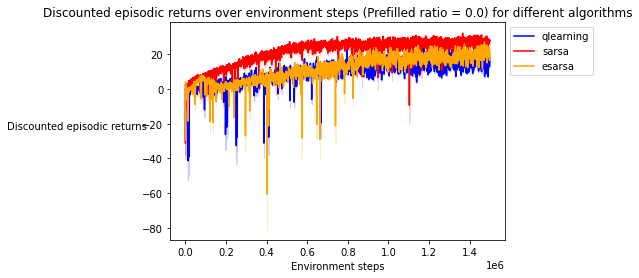

In [44]:
x_alg = np.arange(mapped_rpg_algo_data['sarsa'].shape[1])
alg_fig, alg_ax = plt.figure(), plt.axes()


for key, data in mapped_rpg_algo_data.items():
    means = data.mean(axis=0)
    std_err = data.std(axis=0) / data.shape[0]

    alg_ax.plot(x_alg, means, label=key, color=plot_params[key]['color'])
    plt.fill_between(x_alg, means - std_err, means + std_err,
                         color=plot_params[key]['color'], alpha=0.2)

alg_ax.set_xlabel('Environment steps')
alg_ax.set_ylabel(f"Discounted episodic returns", rotation=0, labelpad=65)
alg_ax.set_title(f'Discounted episodic returns over environment steps (Prefilled ratio = 0.0) for different algorithms')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')


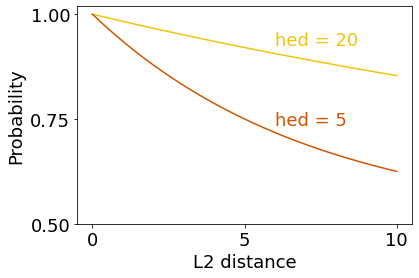

In [15]:
hed_fig_path = Path(ROOT_DIR, 'results', 'hed_plot.pdf')

x_hed = np.linspace(0, 10, 300)
hed_fig, hed_ax = plt.figure(), plt.axes()

hed_vals_20 = np.array([half_dist_prob(hed, 20) for hed in x_hed])
hed_vals_5 = np.array([half_dist_prob(hed, 5) for hed in x_hed])

hed_ax.plot(x_hed, hed_vals_20, color=sunflower)
hed_ax.plot(x_hed, hed_vals_5, color=pumpkin)

plt.text(6, 0.925, "hed = 20", color=sunflower, fontdict=dict(size=18))
plt.text(6, 0.735, "hed = 5", color=pumpkin, fontdict=dict(size=18))

hed_ax.set_xticks([0, 5, 10])
hed_ax.set_yticks([0.5, 0.75, 1])
hed_ax.set_xlabel('L2 distance')
hed_ax.set_ylabel(f"Probability", labelpad=5)

hed_fig.savefig(hed_fig_path, bbox_inches='tight')
